<a href="https://colab.research.google.com/github/Sparsh-mahajan/deep_audio_classification/blob/main/Music_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## New code

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

import warnings

import random
import shutil
from shutil import copyfile
warnings.filterwarnings('ignore')

In [ ]:
source_dir = '/content/drive/MyDrive/Data/images_original'
root_dir = 'tmp/images'

In [ ]:
def create_train_val_dirs(source_path, root_path):
  """
  Creates directories for the train and test sets
  
  Args:
    source_path(string) - the source directory path to the actual dataset
    root_path (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """
  sub_dir_list = os.listdir(source_path)
  for sub_dir in sub_dir_list:
    os.makedirs(os.path.join(root_path, 'training/' + sub_dir))
    os.makedirs(os.path.join(root_path, 'validation/' + sub_dir))

In [ ]:
try:
  create_train_val_dirs(source_path=source_dir ,root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

tmp/images/training
tmp/images/validation
tmp/images/training/country
tmp/images/training/reggae
tmp/images/training/hiphop
tmp/images/training/rock
tmp/images/training/blues
tmp/images/training/jazz
tmp/images/training/disco
tmp/images/training/classical
tmp/images/training/metal
tmp/images/training/pop
tmp/images/validation/country
tmp/images/validation/reggae
tmp/images/validation/hiphop
tmp/images/validation/rock
tmp/images/validation/blues
tmp/images/validation/jazz
tmp/images/validation/disco
tmp/images/validation/classical
tmp/images/validation/metal
tmp/images/validation/pop


In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """
  file_list = os.listdir(SOURCE_DIR)
  
  #remove files that have no size.
  for file_idx, file in enumerate(file_list):
    file_path = os.path.join(SOURCE_DIR, file)
    file_size = os.path.getsize(file_path)
    if(file_size == 0):
      file_list.pop(file_idx)
  
  shuffled_list = random.sample(file_list, len(file_list))
  
  train_idx = (int)(len(file_list) * SPLIT_SIZE)
  train_file_list = shuffled_list[:train_idx]
  val_file_list = shuffled_list[train_idx:]

  def copy_files(SOURCE_DIR, DEST_DIR, file_list):
    for file in file_list:
      file_path = os.path.join(SOURCE_DIR, file)
      copyfile(file_path, os.path.join(DEST_DIR, file))
  
  copy_files(SOURCE_DIR, TRAINING_DIR, train_file_list)
  copy_files(SOURCE_DIR, VALIDATION_DIR, val_file_list)



In [ ]:
#copying the files in the root_dir
for sub_dir in os.listdir(source_dir):
  source_path = os.path.join(source_dir, sub_dir)
  train_target_path = os.path.join(root_dir, 'training/' + sub_dir)
  val_target_path = os.path.join(root_dir, 'validation/' + sub_dir)
  # 80% of the data for training and rest for validation
  split_size = 0.8 

  split_data(source_path, train_target_path, val_target_path, split_size)

In [ ]:
train_dir = os.path.join(root_dir, 'training')
val_dir = os.path.join(root_dir, 'validation')
num_classes = len(os.listdir(train_dir))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rescale = 1./255,
                                    width_shift_range = 0.3,
                                    height_shift_range = 0.3,
                                    zoom_range = 0.3,
                                    #horizontal_flip = True,
                                    fill_mode = 'nearest' )

#test/validation dataset should not be augmented!
val_datagen = ImageDataGenerator( rescale = 1./255)
                                    #width_shift_range = 0.2,
                                    #height_shift_range = 0.2,
                                    #zoom_range = 0.2,
                                    #horizontal_flip = True,
                                    #fill_mode = 'nearest' )

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (256, 256),
                                                    batch_size = 8,
                                                    class_mode = 'categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                  target_size = (256, 256),
                                                  batch_size = 8,
                                                  class_mode = 'categorical')

Found 799 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', padding='valid'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPooling2D(2, padding='same'),

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding='valid'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPooling2D(2, padding='same'),

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding='valid'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPooling2D(2, padding='same'),

    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding='valid'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPooling2D(2, padding='same'),

    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding='valid'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPooling2D(2, padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

In [ ]:
history_with_aug = model.fit(
      train_generator,
      steps_per_epoch=100,  
      epochs=40,
      validation_data=val_generator,
      validation_steps=25,
      verbose=2)

Epoch 1/40
100/100 - 18s - loss: 2.5703 - accuracy: 0.0976 - val_loss: 2.2928 - val_accuracy: 0.1200 - 18s/epoch - 179ms/step
Epoch 2/40
100/100 - 16s - loss: 2.2528 - accuracy: 0.1677 - val_loss: 2.2320 - val_accuracy: 0.2650 - 16s/epoch - 155ms/step
Epoch 3/40
100/100 - 15s - loss: 2.1249 - accuracy: 0.2090 - val_loss: 2.2050 - val_accuracy: 0.1750 - 15s/epoch - 151ms/step
Epoch 4/40
100/100 - 15s - loss: 2.0423 - accuracy: 0.2503 - val_loss: 2.1474 - val_accuracy: 0.1950 - 15s/epoch - 148ms/step
Epoch 5/40
100/100 - 15s - loss: 1.9440 - accuracy: 0.2728 - val_loss: 1.9636 - val_accuracy: 0.3550 - 15s/epoch - 146ms/step
Epoch 6/40
100/100 - 15s - loss: 1.8713 - accuracy: 0.2991 - val_loss: 1.8780 - val_accuracy: 0.3700 - 15s/epoch - 148ms/step
Epoch 7/40
100/100 - 15s - loss: 1.8393 - accuracy: 0.3304 - val_loss: 1.9483 - val_accuracy: 0.2700 - 15s/epoch - 153ms/step
Epoch 8/40
100/100 - 15s - loss: 1.7773 - accuracy: 0.3492 - val_loss: 1.8100 - val_accuracy: 0.4500 - 15s/epoch - 147

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, None, None, 32)    896       
                                                                 
 dropout_7 (Dropout)         (None, None, None, 32)    0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv2d_100 (Conv2D)         (None, None, None, 64)    18496     
                                                                 
 dropout_8 (Dropout)         (None, None, None, 64)    0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, None, None, 64)   0         
 g2D)                                                 

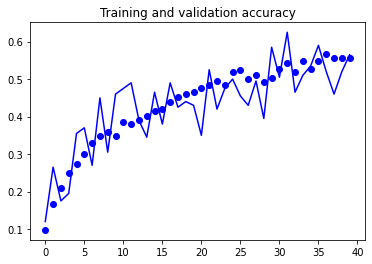

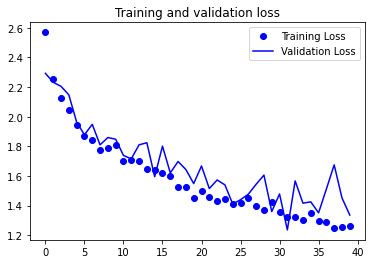

In [ ]:
plot_loss_acc(history_with_aug)

### Transfer learning

In [ ]:
img_shape = (256, 256, 3)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-03-24 20:20:38--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  23.5MB/s    in 4.6s    

2023-03-24 20:20:44 (18.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_104 (Conv2D)            (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_104[0][0]']             
 ormalization)                  )                                                      

In [ ]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 2048)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (10, activation='softmax')(x)

tl_model = Model(pre_trained_model.input, x)
tl_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_104 (Conv2D)            (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_104[0][0]']             
 ormalization)                  )                                                           

In [ ]:
tl_model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
tl_history = tl_model.fit(train_generator,
                          steps_per_epoch=100,  
                          epochs=40,
                          validation_data=val_generator,
                          validation_steps=25,
                          verbose=2)

Epoch 1/40
100/100 - 22s - loss: 0.4835 - accuracy: 0.2278 - val_loss: 0.2856 - val_accuracy: 0.3550 - 22s/epoch - 224ms/step
Epoch 2/40
100/100 - 16s - loss: 0.3051 - accuracy: 0.3317 - val_loss: 0.2599 - val_accuracy: 0.3600 - 16s/epoch - 161ms/step
Epoch 3/40
100/100 - 15s - loss: 0.2850 - accuracy: 0.3630 - val_loss: 0.2627 - val_accuracy: 0.3400 - 15s/epoch - 152ms/step
Epoch 4/40
100/100 - 17s - loss: 0.2703 - accuracy: 0.3617 - val_loss: 0.2400 - val_accuracy: 0.5000 - 17s/epoch - 174ms/step
Epoch 5/40
100/100 - 15s - loss: 0.2649 - accuracy: 0.4193 - val_loss: 0.2335 - val_accuracy: 0.4300 - 15s/epoch - 152ms/step
Epoch 6/40
100/100 - 15s - loss: 0.2581 - accuracy: 0.4193 - val_loss: 0.2256 - val_accuracy: 0.4750 - 15s/epoch - 152ms/step
Epoch 7/40
100/100 - 15s - loss: 0.2554 - accuracy: 0.4418 - val_loss: 0.2432 - val_accuracy: 0.4450 - 15s/epoch - 153ms/step
Epoch 8/40
100/100 - 15s - loss: 0.2414 - accuracy: 0.4618 - val_loss: 0.2432 - val_accuracy: 0.4200 - 15s/epoch - 154

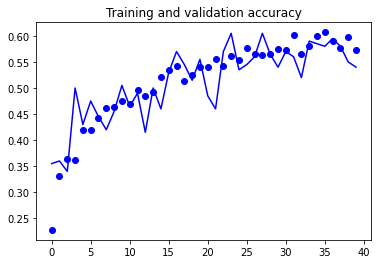

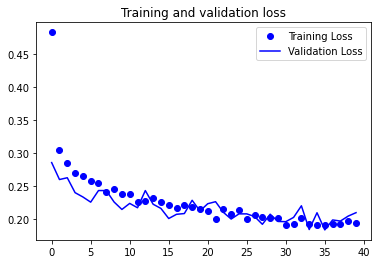

In [ ]:
plot_loss_acc(tl_history)

#### the transfer learning is giving better results therefore, we will work with the transfer learning model as of now and continually improve our model.

In [ ]:
save_path = '/content/drive/MyDrive/saved_models'
try:
  os.makedirs(save_path)
except:
  pass
tl_model_json = tl_model.to_json()
with open(os.path.join(save_path, 'tl_model.json'), "w") as json_file:
  json_file.write(tl_model_json)

tl_model.save_weights(os.path.join(save_path, 'tl_model_weights.h5'))
